The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


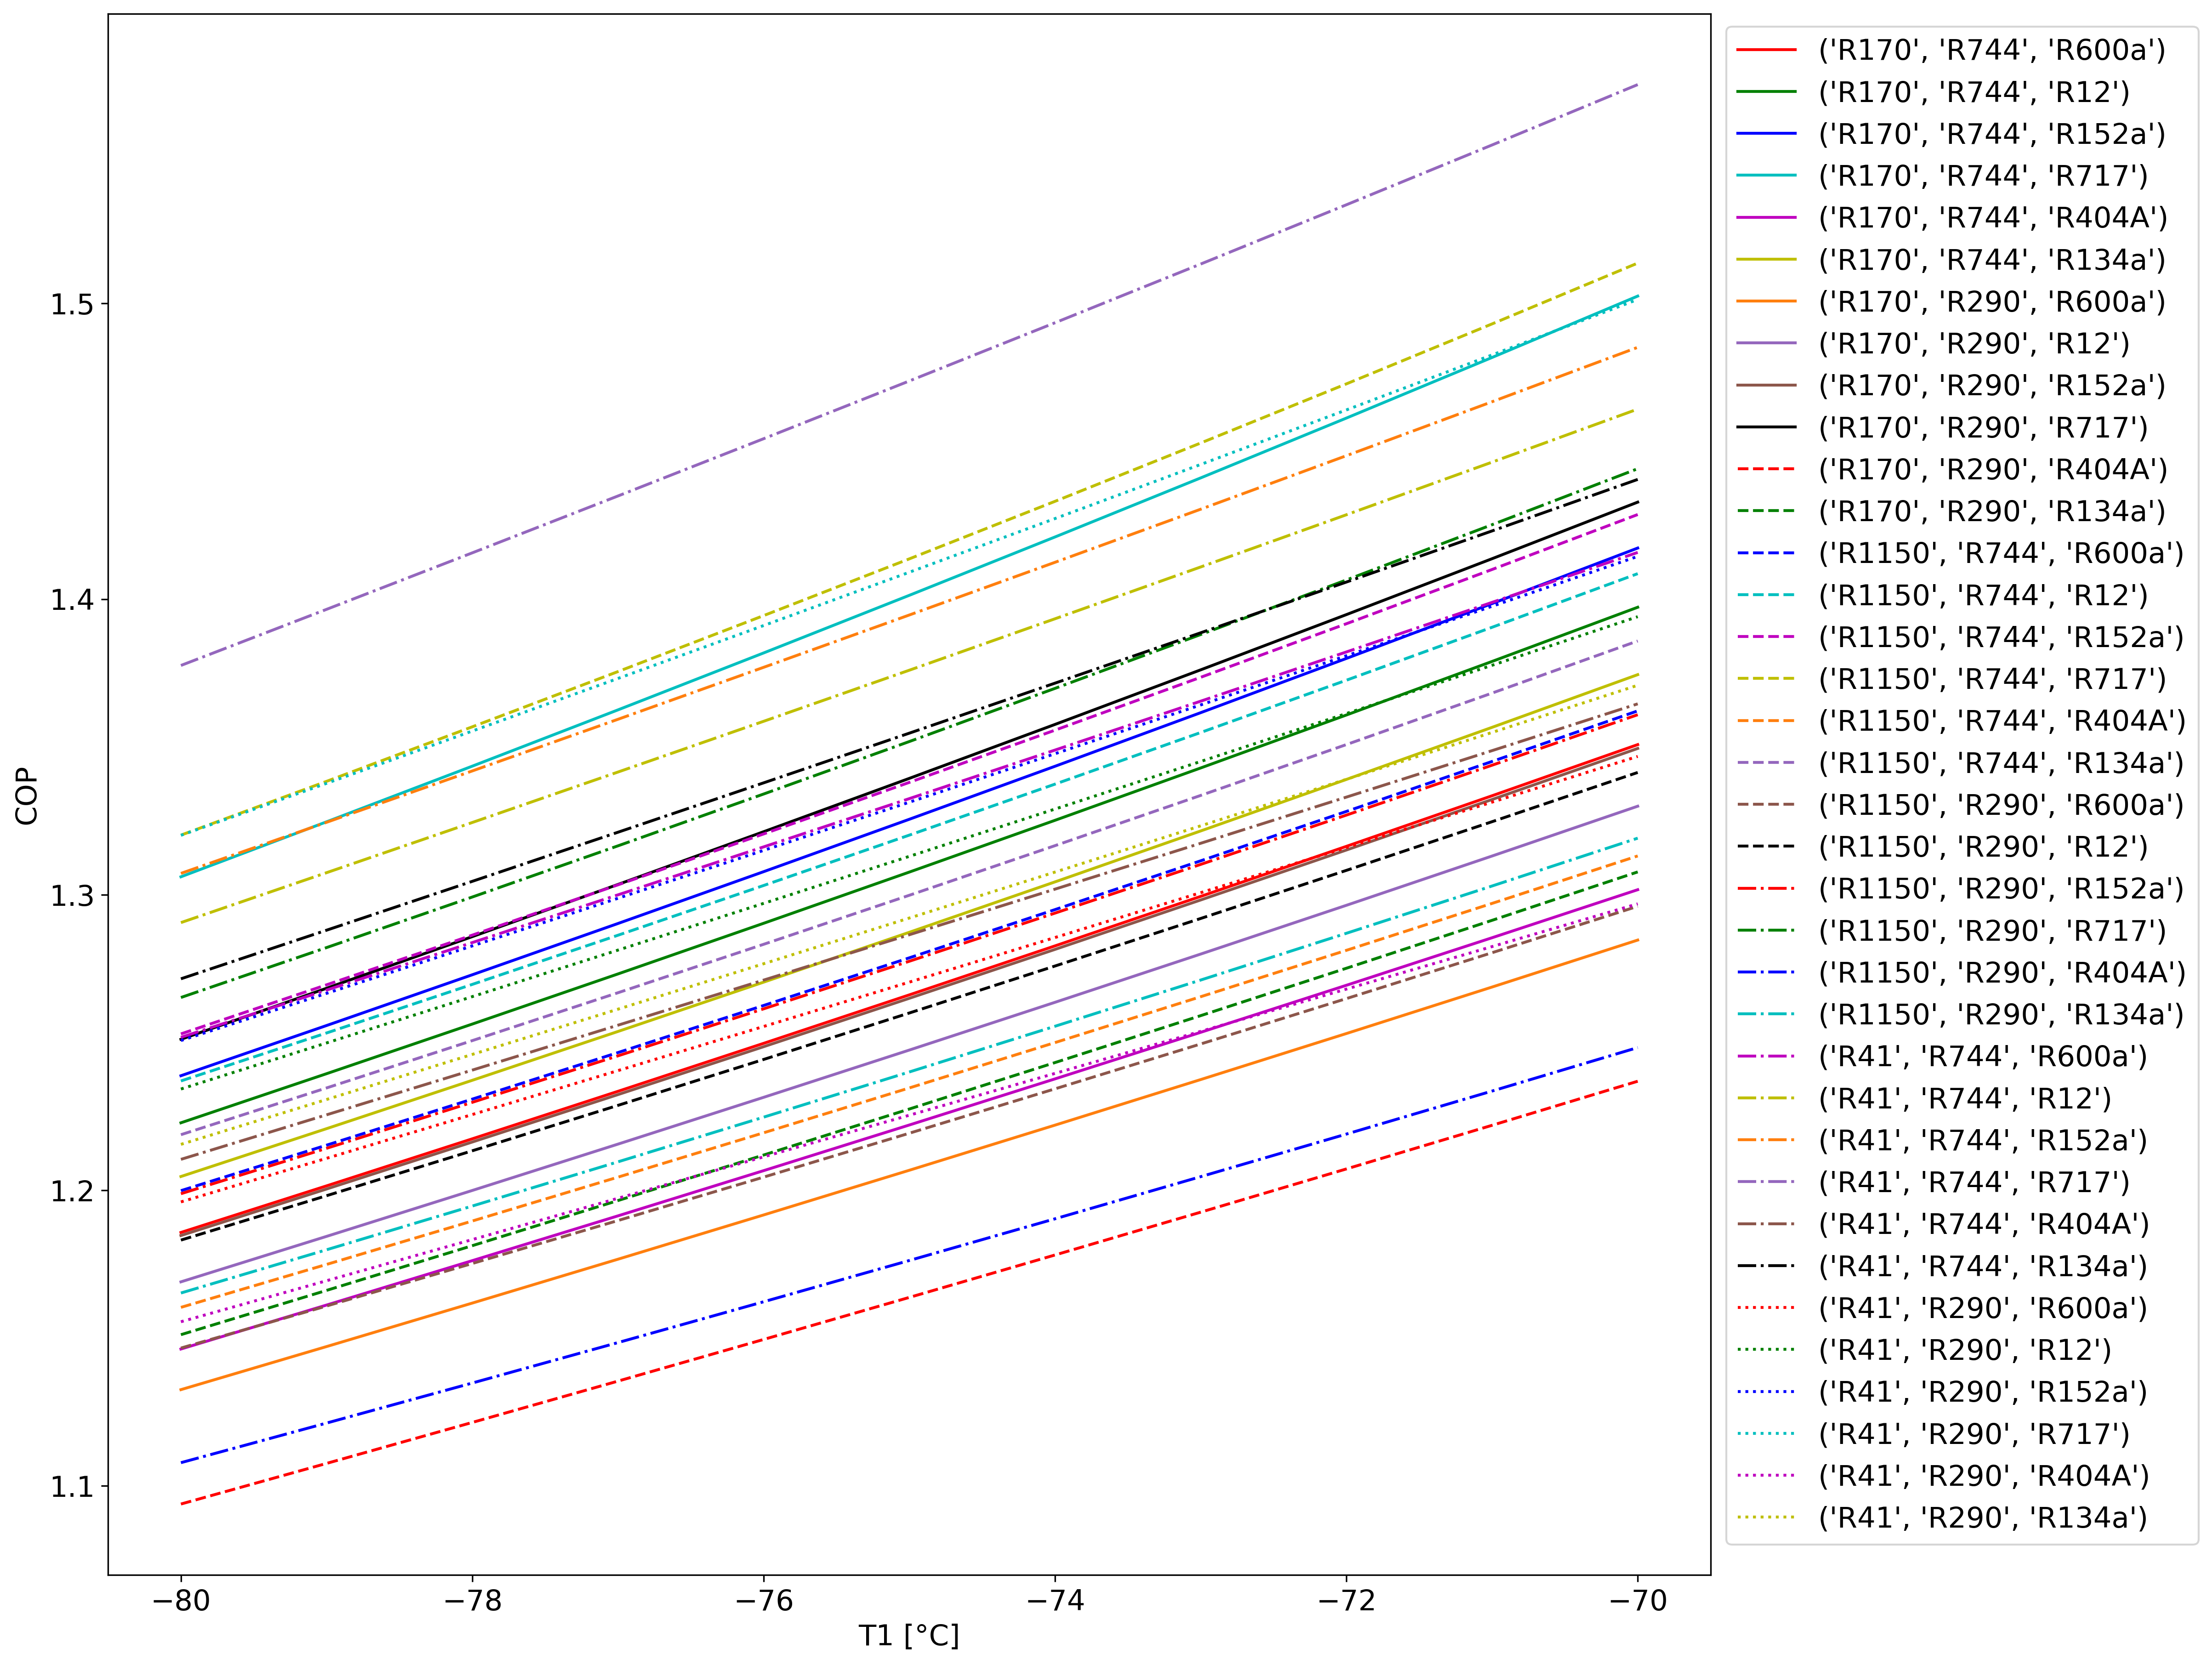

In [1]:
#Bibliotecas
from CoolProp.CoolProp import PropsSI as CP
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data

#Listas
registro_fluidos = []
COP_lista = []
lista_T1 = []
Wcomp_total_lista = []
cont = []

#Lista de coeficientes politrópicos
for T1 in range (-80, -69, 1):
    T1 += 273.15
    cont.append(T1)

#Listas de características para as curvas do gráfico
lista_cor = ['r','g','b', 'c', 'm', 'y', 'tab:orange', 'tab:purple','tab:brown', 'k']
lista_ls = ['-', '--', '-.', ':']
caracteristicas = []
for ls in lista_ls:
    for cor in lista_cor:
        caracteristicas.append((cor, ls))

#Dados do problema
Pfrig = 120 * 1000 #[W]
T3 = -35 + 273.15 #[K]
T5 = -39 + 273.15 #[K]
T7 = -8 + 273.15 #[K]
T9 = -12 + 273.15 #[K]
T11 = 35 + 273.15 #[K]
n = 1.1
fluid_high_lista = ['R600a', 'R12', 'R152a', 'R717', 'R404A', 'R134a']
fluid_medium_lista = ['R744', 'R290']
fluid_low_lista = ['R170', 'R1150', 'R41']
drop_suc = 12000 #[Pa]
drop_desc = 24000 #[Pa]

#Loop nos três ciclos - variação dos refrigerantes e do coeficiente politrópico
for fluid_low in fluid_low_lista:
    for fluid_medium in fluid_medium_lista:
        for fluid_high in fluid_high_lista:
            conj_fluido = (fluid_low, fluid_medium, fluid_high)
            registro_fluidos.append(conj_fluido)
            for T1 in cont:
                #Pressão crítica do fluido superior:
                P_crit_high = CP('PCRIT', fluid_high)
                #Ciclo inferior
                P1 = CP('P', 'T', T1, 'Q', 1, fluid_low) 
                h1 = CP('H', 'T', T1, 'Q', 1, fluid_low)
                ha = h1
                Pa = P1 - drop_suc
                Ta = CP('T', 'H', ha, 'P', Pa, fluid_low)
                Pb = Pa
                Tb = Ta + 4 #superaquecimento de 4°C na admissão
                vb = 1 / CP('D', 'T', Tb, 'P', Pb, fluid_low)
                P3 = CP('P', 'T', T3, 'Q', 0 , fluid_low)
                P2 = P3
                Pc = P2 + drop_desc
                h3 = CP('H', 'T', T3, 'Q', 0, fluid_low)
                h4 = h3
                m_flow_low = Pfrig / (h1 - h4)
                #Ciclo intermediário
                P5 = CP('P', 'T', T5, 'Q', 1, fluid_medium)
                h5 = CP('H', 'T', T5, 'Q', 1, fluid_medium)
                hw = h5
                Pw = P5 - drop_suc
                Tw = CP('T', 'H', hw, 'P', Pw, fluid_medium)
                Px = Pw
                Tx = Tw + 4 #superaquecimento de 4°C na admissão
                vx = 1 / CP('D', 'T', Tx, 'P', Px, fluid_medium)
                P7 = CP('P', 'T', T7, 'Q', 0, fluid_medium)
                P6 = P7
                Py = P6 + drop_desc
                h7 = CP('H', 'T', T7, 'Q', 0, fluid_medium)
                h8 = h7
                #Ciclo superior
                P9 = CP('P', 'T', T9, 'Q', 1, fluid_high)
                h9 = CP('H', 'T', T9, 'Q', 1, fluid_high)
                he = h9
                Pe = P9 - drop_suc
                Te = CP('T', 'H', he, 'P', Pe, fluid_high)
                Pf = Pe
                Tf = Te + 4 #superaquecimento de 4°C na admissão
                vf = 1 / CP('D', 'T', Tf, 'P', Pf, fluid_high)
                P11 = CP('P', 'T', T11, 'Q', 0, fluid_high)
                P10 = P11
                Pg = P10 + drop_desc
                h11 = CP('H', 'T', T11, 'Q', 0, fluid_high)
                h12 = h11
                #Ciclo inferior
                vc = (Pb * vb ** n / Pc)**(1 / n)
                hc = CP('H', 'P', Pc, 'D', 1 / vc, fluid_low)
                h2 = hc
                #Trabalho específico do compressor do ciclo inferior
                w_low = n / (n-1) * Pb * vb * ((Pc/Pb)**((n-1)/n) - 1)
                #Trabalho do compressor do ciclo inferior
                Wcomp_low = m_flow_low * w_low
                #Calor trocado no trocador entre o ciclo inferior e o intermediário
                Qcond_low =  m_flow_low * (h2 - h3)
                #Ciclo intermediário
                Qevap_medium = Qcond_low
                m_flow_medium = Qevap_medium / (h5 - h8)
                vy = (Px * vx ** n / Py)**(1 / n)
                hy = CP('H', 'P', Py, 'D', 1 / vy, fluid_medium)
                h6 = hy
                #Trabalho específico do compressor do ciclo intermediário
                w_medium = n / (n-1) * Px * vx * ((Py/Px)**((n-1)/n) - 1)
                #Trabalho no compressor do ciclo intermediário
                Wcomp_medium = m_flow_medium * w_medium
                #Calor trocado no trocador entre o ciclo intermediário e o superior
                Qcond_medium = m_flow_medium * (h6 - h7)
                #Ciclo superior
                Qevap_high = Qcond_medium
                m_flow_high = Qevap_high / (h9 - h12)
                vg = (Pf * vf ** n / Pg)**(1 / n)
                #Verificação da pressão crítica
                if P_crit_high > P10:
                    lista_T1.append(T1-273.15)
                    #Trabalho específico do compressor do ciclo superior
                    w_high = n / (n-1) * Pf * vf * ((Pg/Pf)**((n-1)/n) - 1)
                    #Trabalho no compressor do ciclo superior
                    Wcomp_high = m_flow_high * w_high
                    #Trabalho total do ciclo
                    Wcomp_total = Wcomp_low + Wcomp_medium + Wcomp_high
                    Wcomp_total_lista.append(Wcomp_total / 1000)
                    #COP
                    COP = Pfrig / Wcomp_total
                    COP_lista.append(COP)
                else:
                    print ('A pressão P10 = {:0.2f} kPa (n = {}, fluido inf = {}, '
                            'fluido med = {}, fluido sup = {}) é maior do que a pressão crítica do {} e, '
                            'por isso, o ponto não foi incluído no gráfico'.
                            format(P10 / 1000,n,fluid_low, fluid_medium, fluid_high, fluid_high))                    

if len(lista_T1) != 0:
    plt.rc('xtick', labelsize = 15)
    plt.rc('ytick', labelsize = 15)
    plt.figure(figsize = [15, 15], dpi = 300)
    for i in range (0, len(COP_lista), len(cont)):
        eixo_x = []
        eixo_y = []
        for j in range (i, i + len(cont), 1):
            eixo_x.append(lista_T1[j])
            eixo_y.append(COP_lista[j])
        plt.plot(eixo_x, eixo_y, color = caracteristicas[int(i/len(cont))][0], 
                 linestyle = caracteristicas [int(i/len(cont))][1], label=registro_fluidos[int(i/len(cont))])
        plt.xlabel('T1 [°C]', size = 15)
        plt.ylabel('COP', size = 15)
    plt.legend(prop={'size' : 15}, bbox_to_anchor =(1.001, 1.001))
    plt.savefig('cs3erefevap.eps', format='eps', bbox_inches = 'tight')
    plt.show()
else:
    print('Todos os pontos são inválidos')
